In [ ]:
import os
# Find the latest version of spark 3.0  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
spark_version = 'spark-3.0.3'
#spark_version = 'spark-3.<enter version>'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:15 http://ppa.launchpad.net/graph

In [ ]:
# First, enter the following code to download a Postgres driver that will allow Spark to interact with Postgres:
!wget https://jdbc.postgresql.org/download/postgresql-42.2.16.jar

--2021-07-30 22:55:39--  https://jdbc.postgresql.org/download/postgresql-42.2.16.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1002883 (979K) [application/java-archive]
Saving to: ‘postgresql-42.2.16.jar.7’

postgresql-42.2.16. 100%[===================>] 979.38K  5.95MB/s    in 0.2s    

2021-07-30 22:55:39 (5.95 MB/s) - ‘postgresql-42.2.16.jar.7’ saved [1002883/1002883]



In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Final_data").config("spark.driver.extraClassPath","/content/postgresql-42.2.16.jar").getOrCreate()

In [ ]:
# Load in a sql functions
from pyspark.sql.functions import col, avg, sum, count, rand, randn, to_timestamp

In [ ]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
url = "https://tq2cutebucket.s3.us-west-1.amazonaws.com/final_data2.csv"
spark.sparkContext.addFile(url)
df = spark.read.option("encoding", "UTF-8").csv(SparkFiles.get("final_data2.csv"), sep=",", header=True, inferSchema=True)
df.show()

+--------------+--------------------+--------+------------+------------+---------+----------+----------+---+-----------+--------+---+--------------+--------------+----------+
|    MLS Number|      Street Address|zip_code|      county|County_Index|Year_Sale|List Price|Sale Price|Age|Sq Ft Total|Lot Size|DOM|  Listing Date|     Sale Date|Year Built|
+--------------+--------------------+--------+------------+------------+---------+----------+----------+---+-----------+--------+---+--------------+--------------+----------+
|     CRP1-5385|   1428 Hacienda DR |   91011| Los Angeles|           0|     2021|   2800000|   2780000| 56|       3637| 17421.0| 36|5/18/2021 0:00|6/23/2021 0:00|      1965|
|  CNSR21123928| 19458 Maldonado PL |   91350| Los Angeles|           0|     2021|    831000|    831000|  3|       1943|  5811.0| 12|6/10/2021 0:00|6/22/2021 0:00|      2018|
|  CROC21112305|  29069 Sterling LN |   91354| Los Angeles|           0|     2021|    928000|    925000|  7|       2796|  532

In [ ]:
# filter function
# vine_votes = vine_df.filter("total_votes > 20")
# vine_votes.show()

data_df = df.filter("County_Index < 10")

In [ ]:
# import sql function pyspark
import pyspark.sql.functions as f

# null values in each column
data_agg = df.agg(*[f.count(f.when(f.isnull(c), c)).alias(c) for c in df.columns])
data_agg.show()

+----------+--------------+--------+------+------------+---------+----------+----------+---+-----------+--------+---+------------+---------+----------+
|MLS Number|Street Address|zip_code|county|County_Index|Year_Sale|List Price|Sale Price|Age|Sq Ft Total|Lot Size|DOM|Listing Date|Sale Date|Year Built|
+----------+--------------+--------+------+------------+---------+----------+----------+---+-----------+--------+---+------------+---------+----------+
|         0|             0|       0|     0|           0|        0|         0|         0|  0|          0|       0|  0|           0|        0|         0|
+----------+--------------+--------+------+------------+---------+----------+----------+---+-----------+--------+---+------------+---------+----------+



In [ ]:
#import pandas
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
df.count()

8380

In [ ]:
df.printSchema()

root
 |-- MLS Number: string (nullable = true)
 |-- Street Address: string (nullable = true)
 |-- zip_code: integer (nullable = true)
 |-- county: string (nullable = true)
 |-- County_Index: integer (nullable = true)
 |-- Year_Sale: integer (nullable = true)
 |-- List Price: integer (nullable = true)
 |-- Sale Price: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Sq Ft Total: integer (nullable = true)
 |-- Lot Size: double (nullable = true)
 |-- DOM: integer (nullable = true)
 |-- Listing Date: string (nullable = true)
 |-- Sale Date: string (nullable = true)
 |-- Year Built: integer (nullable = true)



In [ ]:
df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
MLS Number,8380,None,None,BA321030025,TM21-762052
Street Address,8380,None,None,"""'""1595 '""'""C'""'"" Josselyn Canyon RD '""""",9989 La Porte RD
zip_code,8380,93733.22840095466,1761.0926385734203,90002,96161
county,8380,None,None,Alameda,Yuba
County_Index,8380,7.523150357995227,7.796940385094982,0,44
Year_Sale,8380,2020.909307875895,0.37829177194192,2019,2021
List Price,8380,1038517.646778043,1041465.4783596672,75000,15868000
Sale Price,8380,1108018.570405728,1081878.8042877018,72000,15350000
Age,8380,46.71766109785203,26.720590810932638,0,152


In [ ]:
#reg_df = df.select("County_Index","Sq Ft Total","Lot Size","Age","DOM","List Price","Sale Price")
reg_df = df.select("County_Index","Year_Sale","Sq Ft Total","Lot Size","Age","List Price","Sale Price")
reg_df.show()
reg_df.count()

+------------+---------+-----------+--------+---+----------+----------+
|County_Index|Year_Sale|Sq Ft Total|Lot Size|Age|List Price|Sale Price|
+------------+---------+-----------+--------+---+----------+----------+
|           0|     2021|       3637| 17421.0| 56|   2800000|   2780000|
|           0|     2021|       1943|  5811.0|  3|    831000|    831000|
|           0|     2021|       2796|  5329.0|  7|    928000|    925000|
|           0|     2021|       4749| 13874.0| 21|   2512500|   2512500|
|           7|     2021|       1964|  4271.0| 40|    699000|    730000|
|           3|     2021|       2086|  7405.0| 22|    535000|    580000|
|           3|     2021|       1611|  2223.0|  3|    450000|    500000|
|           1|     2021|       1217|  4950.0| 50|    940000|    940000|
|           1|     2021|        600|   800.0| 56|    425000|    435000|
|           1|     2021|       3829| 13189.0| 22|   2300000|   2300000|
|          12|     2019|       1208|  7003.0| 60|    540000|    

8380

In [ ]:
data_array = np.array(reg_df.collect())
data_array

array([[0.000e+00, 2.021e+03, 3.637e+03, ..., 5.600e+01, 2.800e+06,
        2.780e+06],
       [0.000e+00, 2.021e+03, 1.943e+03, ..., 3.000e+00, 8.310e+05,
        8.310e+05],
       [0.000e+00, 2.021e+03, 2.796e+03, ..., 7.000e+00, 9.280e+05,
        9.250e+05],
       ...,
       [9.000e+00, 2.019e+03, 2.268e+03, ..., 1.300e+01, 3.290e+05,
        3.290e+05],
       [9.000e+00, 2.021e+03, 1.578e+03, ..., 5.700e+01, 3.120e+05,
        3.250e+05],
       [1.800e+01, 2.021e+03, 1.189e+03, ..., 4.500e+01, 4.000e+05,
        4.450e+05]])

In [ ]:
X = data_array[1:4211:,0:6]
Y = data_array[1:4211:,6:7]
print(X)
print(Y)

[[0.0000e+00 2.0210e+03 1.9430e+03 5.8110e+03 3.0000e+00 8.3100e+05]
 [0.0000e+00 2.0210e+03 2.7960e+03 5.3290e+03 7.0000e+00 9.2800e+05]
 [0.0000e+00 2.0210e+03 4.7490e+03 1.3874e+04 2.1000e+01 2.5125e+06]
 ...
 [1.3000e+01 2.0210e+03 1.3020e+03 1.9423e+04 6.9000e+01 8.7500e+05]
 [2.0000e+00 2.0210e+03 1.1590e+03 6.5990e+03 6.6000e+01 4.6900e+05]
 [9.0000e+00 2.0190e+03 1.5120e+03 4.3996e+04 3.9000e+01 2.1990e+05]]
[[ 831000.]
 [ 925000.]
 [2512500.]
 ...
 [ 915000.]
 [ 508500.]
 [ 219900.]]


In [ ]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X_scale = min_max_scaler.fit_transform(X)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X_scale, Y, test_size=0.3)

In [ ]:
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)

In [ ]:
print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)

(2947, 6) (631, 6) (632, 6) (2947, 1) (631, 1) (632, 1)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
model = Sequential([
    Dense(32, activation='relu', input_shape=(6,)),
    Dense(5, activation='sigmoid'),
    Dense(5, activation='relu'),
])

#model = Sequential([
#    Dense(32, activation='relu', input_shape=(5,)),
#    Dense(32, activation='relu'),
#    Dense(1, activation='sigmoid'),
#])

In [ ]:
model.compile(optimizer='Adam',
              loss='MSE',
              metrics=['MSE'])

#model.compile(optimizer='sgd',
#              loss='binary_crossentropy',
#              metrics=['accuracy'])

# optimizer: RMSPROP, SGD, AdaGrad, Adadelta, Adam
# loss function: MSE, BCE, CC, SCC
# metrics: MSE, accuracy, Log Loss,

In [ ]:
hist = model.fit(X_train, Y_train,
          batch_size=32, epochs=100,
          validation_data=(X_val, Y_val))

Epoch 1/100
93/93 [==============================] - 1s 4ms/step - loss: 2806008092802.7236 - MSE: 2806008092802.7236 - val_loss: 2111266619392.0000 - val_MSE: 2111266619392.0000
Epoch 2/100
93/93 [==============================] - 0s 2ms/step - loss: 2550436171165.9575 - MSE: 2550436171165.9575 - val_loss: 2111265308672.0000 - val_MSE: 2111265308672.0000
Epoch 3/100
93/93 [==============================] - 0s 2ms/step - loss: 2265160341983.3193 - MSE: 2265160341983.3193 - val_loss: 2111264391168.0000 - val_MSE: 2111264391168.0000
Epoch 4/100
93/93 [==============================] - 0s 2ms/step - loss: 2659894963091.0640 - MSE: 2659894963091.0640 - val_loss: 2111263604736.0000 - val_MSE: 2111263604736.0000
Epoch 5/100
93/93 [==============================] - 0s 2ms/step - loss: 2576616014172.5957 - MSE: 2576616014172.5957 - val_loss: 2111262556160.0000 - val_MSE: 2111262556160.0000
Epoch 6/100
93/93 [==============================] - 0s 2ms/step - loss: 2646049162610.3828 - MSE: 264604

In [ ]:
model.evaluate(X_test, Y_test)[1]

20/20 [==============================] - 0s 1ms/step - loss: 2037461680128.0000 - MSE: 2037461680128.0000


2037461680128.0

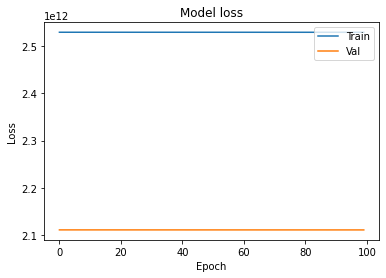

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()